#1.Configuracion del ambiente
Para empezar, se ha utilizado el entorno virtual Google Colaboratory. Se importaron algunas librerias de Python esenciales para este proyecto, como Pandas, Numpy, Matplotlib, etc

In [ ]:
#librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from urllib.request import urlopen
import requests
from bs4 import BeautifulSoup

import time
from IPython.display import clear_output

#1.a.Variables globales
df_bitcoin: Esta variable tiene el dataframe de los precios historicos del bitcoin

precio_actual: precio actual del bitcoin

tendencia: si el precio del bitcoin es alta o baja

media_bitcoin: promedio de la variable Close (cierre precio)

algoritmo_decision: Dependiendo de las condiciones, realizará una compra, venta o esperar.

#2.Obtencion de datos
Se accede a una API que proporcione datos históricos de precios de Bitcoin en formato JSON, en este caso es la API yahoo Finance.
Utilizando la biblioteca BeautifulSoup se realizara Web Scraping de la página https://coinmarketcap.com/ para extraer el precio actual del Bitcoin BTC en dólares USD y la variación de su precio en la última hora 1h % . El precio se convertirá a float y guardardado en la variable llamada precio_actual. En la variable tendencia se guardara el valor de 'baja'si la variación del precio es negativa, sino, guarda el valor de 'alta'.

In [ ]:
def importar_base_bitcoin():
  global df_bitcoin #variable que guarda los precios historicos
  df = yf.download("BTC-USD", period = "7d", interval = "5m") #df que 'rescata' la data historica
  df_bitcoin = pd.DataFrame(df) #transformamos uestra variable df_bitcoin a DataFrame
  return(df_bitcoin)

In [ ]:
importar_base_bitcoin() #llamar a la funcion
df_bitcoin

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2023-10-25 00:00:00+00:00,33916.042969,33941.207031,33916.042969,33941.207031,33941.207031,0
2023-10-25 00:05:00+00:00,33938.441406,33942.093750,33914.734375,33936.296875,33936.296875,0
2023-10-25 00:10:00+00:00,33935.175781,33950.281250,33886.140625,33886.140625,33886.140625,0
2023-10-25 00:15:00+00:00,33852.980469,33910.554688,33852.980469,33910.554688,33910.554688,16486400
2023-10-25 00:20:00+00:00,33933.507812,33934.132812,33913.386719,33913.386719,33913.386719,0
...,...,...,...,...,...,...
2023-10-31 00:35:00+00:00,34545.847656,34565.457031,34545.847656,34565.457031,34565.457031,14649344
2023-10-31 00:40:00+00:00,34567.636719,34613.289062,34567.636719,34613.289062,34613.289062,41693184
2023-10-31 00:45:00+00:00,34598.324219,34598.324219,34579.851562,34581.312500,34581.312500,43053056


In [ ]:
def extraer_tendencias():
    global precio_actual, variacion_1h, tendencia
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/118.0.0.0 Safari/537.36 Edg/118.0.2088.57'}
    url = 'https://coinmarketcap.com/'
    respuesta = requests.get(url, headers=headers)
    s = BeautifulSoup(respuesta.content, features="lxml")

    # Extraer precio actual
    precio_element = s.find('a', {'href': "/currencies/bitcoin/#markets"})
    if precio_element and precio_element.find('span'):  #rimero, verifica si precio_element existe (es decir, no es None). precio_element debería contener el elemento HTML que encontramos previamente y  que contiene el precio actual de Bitcoin. precio_element.find('span'): Luego, verifica si dentro de precio_element podemos encontrar un elemento span.
        precio_actual = float(precio_element.find('span').get_text().replace("$", "").replace(",", ""))
    else:
        print("Precio actual no encontrado")
        precio_actual = None

    # Extraer variación en 1 hora y determinar tendencia
    variacion_element = s.find('span', {'class': ["sc-d55c02b-0 iwhBxy", "sc-d55c02b-0 gUnzUB"]})
    if variacion_element:
        variacion_1h = float(variacion_element.get_text().replace("%", ""))
        tendencia = 'Alta' if 'iwhBxy' in variacion_element['class'] else 'Baja'
    else:
        print("Variación en 1 hora no encontrada")
        variacion_1h = None
        tendencia = 'No se encuentra tendencia'

    return [precio_actual, variacion_1h, tendencia]


In [ ]:
extraer_tendencias()

[34523.01, 0.07, 'Alta']

#3.Limpieza de datos

Antes de limpiar la base, se crea una copia de la base df_bitcoin para que realice la limpieza en esta nueva base(df_bitcoin_limpio), sin modificar la base original, además es importante entender su contenido:

Datetime: Es el índice del dataframe, y contiene la fecha y hora del intervalo seleccionado, no puede estar duplicado.

Open: Contiene el precio del Bitcoin al inicio del intervalo.

High: Contiene el precio más alto del Bitcoin durante el intervalo.

Low: Contiene el precio más bajo del Bitcoin durante el intervalo.

Close: Contiene el precio del Bitcoin al final del intervalo.

Volume: Contiene el total de transacciones hechas durante el intervalo.

Para la limpieza utilizaremos los atributos Datetime, Close y Volume.

Se analiza la base df_bitcoin_limpio, se identifican duplicados en el índice y se tratan para que queden con sólo índices únicos.

Luego se busca por valores nulos en la columna Close y se tratan.

Se verifica que todos los registros de la base tengan un Volume de transacción mayor a 0, caso contrário, se eliminan.

Se identifican y eliminar los outliers en el precio del Bitcoin, columna Close, se utiliza un gráfico de boxplot para identificarlos.

Se Filtra o selecciona únicamente los registros cuyo precio(Close) se encuentren entre el 1er cuartil(Q1) y el 3er cuartil(Q3) del boxplot.

Finalmente,se  calcula el precio promedio(Close) de esta selección y se guarda en la variable media_bitcoin.

In [ ]:
data = df_bitcoin #se crea una copia de la base original
df_bitcoin_limpio = data.copy()

In [ ]:
def limpieza_datos():
  global df_bitcoin_limpio, media_bitcoin
  df_bitcoin_limpio = df_bitcoin_limpio[['Close','Volume']] #Se seleccionan solo las columnas 'Close' y 'Volume' del DataFrame df_bitcoin_limpio
  duplicated_index = df_bitcoin_limpio.index.duplicated()  #Primero, se identifican las filas con índices duplicados. Luego, se usan estos índices para filtrar y mantener solo las filas que no están duplicadas (indicado por ~)
  df_bitcoin_limpio = df_bitcoin_limpio[~duplicated_index]
  df_bitcoin_limpio = df_bitcoin_limpio.fillna({'Volume': 0})
  df_volume = df_bitcoin_limpio['Volume'] > 0 #Los valores nulos en la columna 'Volume' se reemplazan con 0. Luego, se eliminan las filas donde 'Volume' es 0.
  df_bitcoin_limpio = df_bitcoin_limpio[df_volume]
  df_bitcoin_limpio['Close'] = df_bitcoin_limpio['Close'].fillna(0)# Rellenar valores nulos con cero
  df_bitcoin_limpio = df_bitcoin_limpio[df_bitcoin_limpio['Close'] != 0]# Eliminar las filas donde 'Close' es 0 (mantiene los datos distintos de 0)

  q1 = df_bitcoin_limpio['Close'].quantile(0.25) # Se calculca el primer y tercer cuartil
  q3 = df_bitcoin_limpio['Close'].quantile(0.75)
  box = ((df_bitcoin_limpio['Close'] >= q1) & (df_bitcoin_limpio['Close'] <= q3)) #Solo se mantienen los datos que están entre estos dos cuartiles, eliminando así los valores atípicos (outliers)
  df_bitcoin_limpio = df_bitcoin_limpio[box]

  media_bitcoin = df_bitcoin_limpio['Close'].mean() #Se calcula la media de los datos 'Close' limpios y se almacena en media_bitcoin.
  return media_bitcoin #La función devuelve media_bitcoin, que es el valor medio de los precios de cierre de Bitcoin tras la limpieza de datos



El promedio de los datos es: 34361.69734375


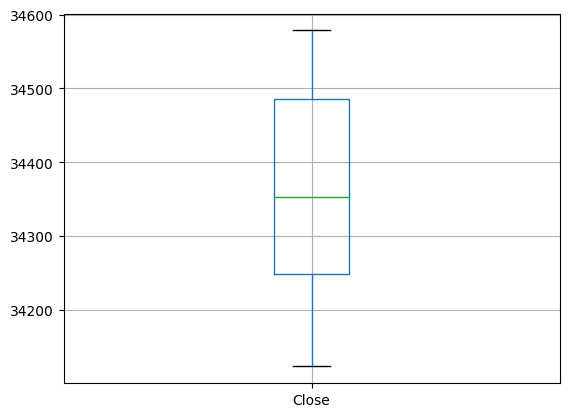

In [ ]:
limpieza_datos()
df_bitcoin_limpio.boxplot(['Close']) #código crea un boxplot (diagrama de caja) para la columna 'Close' del DataFrame df_bitcoin_limpio
print(f'El promedio de los datos es: {media_bitcoin}')

#4.Tomar decisiones
Algoritmo de decisión:

Se crea una funcion tomar_decisiones().

Se rellena la variable algoritmo_decision con el valor resultante del siguiente criterio de decisión:

Si el precio actual es mayor/igual que el precio promedio y la tendencia es de baja, entonces guarda el valor ‘Vender’.

Si el precio actual es menor que el precio promedio y la tendencia es de alta, entonces guarda el valor ‘Comprar’.

Si ninguna de las 2 condiciones anteriores se cumple, entonces guarda 'Esperar'


In [ ]:
def tomar_decisiones():
  global tendencia, precio_actual, media_bitcoin, df_bitcoin, variacion_1h
  precio_actual = extraer_tendencias()[0] #precio_actual extrae los datos de la funcion extraer_tendecias, que para este caso el indice 0, es el precio actual de bitcoin
  tendencia = extraer_tendencias()[2] #tendencia, extrae los datos de la funcion extraer_tendecias, que para este caso el indice 2 es la tendencia del bitcoin (alta o baja)
  if precio_actual>=media_bitcoin and tendencia == 'Baja':
    algoritmo_decision = 'Vender'
  elif precio_actual < media_bitcoin and tendencia != 'Baja':
    algoritmo_decision = 'Comprar'
  else:
    algoritmo_decision = 'Esperar'
  return algoritmo_decision

In [ ]:
algoritmo_decision=tomar_decisiones()
print('Precio Promedio: ',media_bitcoin)
print('Precio Actual: ',precio_actual)
print('Tendencia: ',tendencia)
print('Decision del algoritmo: ',algoritmo_decision)

Precio Promedio:  34361.69734375
Precio Actual:  34523.01
Tendencia:  Alta
Decision del algoritmo:  Esperar


#5.Visualización
Se crea una funcion visualizacion()

Se adiciona una nueva columna (Promedio) al dataframe original df_bitcoin y almacena el valor de nuestra variable media_bitcoin.

Se configura el tamaño del gráfico en una proporción de 16x5.

Usando el método plot()se dibuja una línea en el gráfico, con los datos del índice y la columna Close de la base df_bitcoin.

Usando el método plot()dibuja una línea en el gráfico, con los datos del índice y la columna Promedio de la base df_bitcoin.

Usando el método annotate()muestra un mensaje dentro del gráfico con la decisión calculada del algoritmo.

Finalmente, usando el método show()muestra en pantalla el gráfico que acabamos de configurar.

In [ ]:
def visualizacion():
    global df_bitcoin, precio_actual, algoritmo_decision, df_bitcoin_limpio, tendencia, media_bitcoin
    df_bitcoin['Promedio'] = media_bitcoin #Añade una nueva columna llamada 'Promedio' al DataFrame df_bitcoin, y establece su valor de la variable media_bitcoin, que es el promedio de Bitcon
    plt.figure(figsize=(16,5))
    plt.plot(df_bitcoin.index, df_bitcoin['Close']) #Dibuja una línea gráfica representando los precios de cierre de Bitcoin ('Close') a lo largo del tiempo
    plt.plot(df_bitcoin.index, df_bitcoin['Promedio']) #Dibuja una segunda línea gráfica en la misma figura que representa el precio medio de Bitcoin ('Promedio') a lo largo del tiempo.
    plt.xlabel('Fecha')
    plt.ylabel('Precio')
    plt.annotate(f'Decisión: {algoritmo_decision}', xy=(df_bitcoin.index[-1], df_bitcoin['Close'].iloc[-1]), xytext=(-130, 110), textcoords='offset points', arrowprops=dict(arrowstyle='->'), fontsize=14, color='purple') #Establece 'Fecha' como la etiqueta para el eje x y 'Precio' para el eje y.
                                                                                                  #Añade una anotación en el gráfico que muestra la última "Decisión" tomada por el algoritmo de trading. Esta anotación se coloca cerca del último punto de datos en el gráfico, con un texto que indica la decisión y una flecha que apunta a la posición del último precio de cierre.
    plt.title('Robot Trading')
    plt.show()



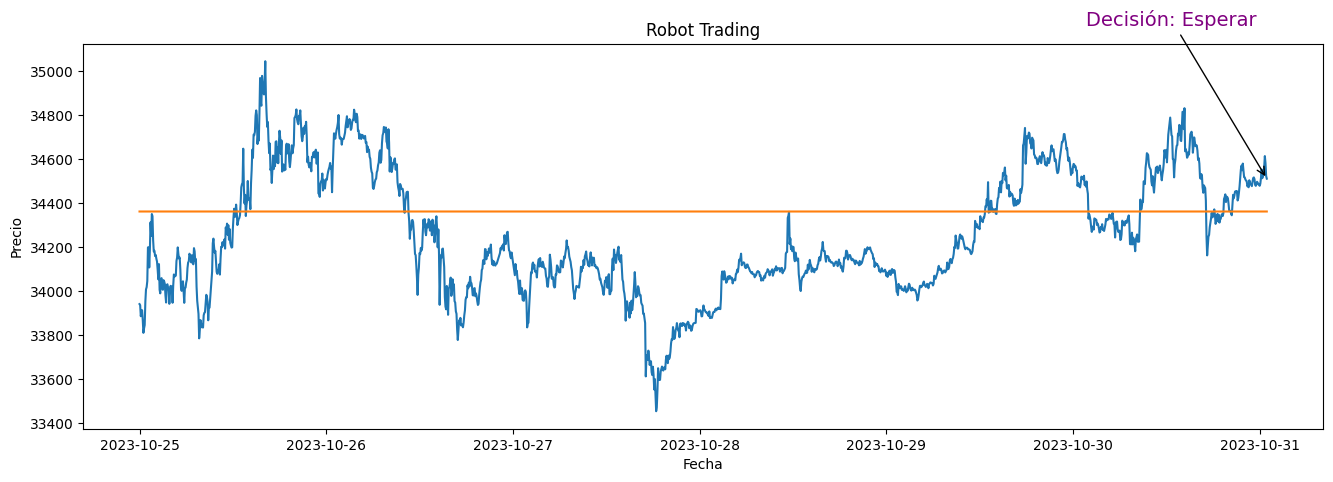

In [ ]:
visualizacion()

[*********************100%%**********************]  1 of 1 completed


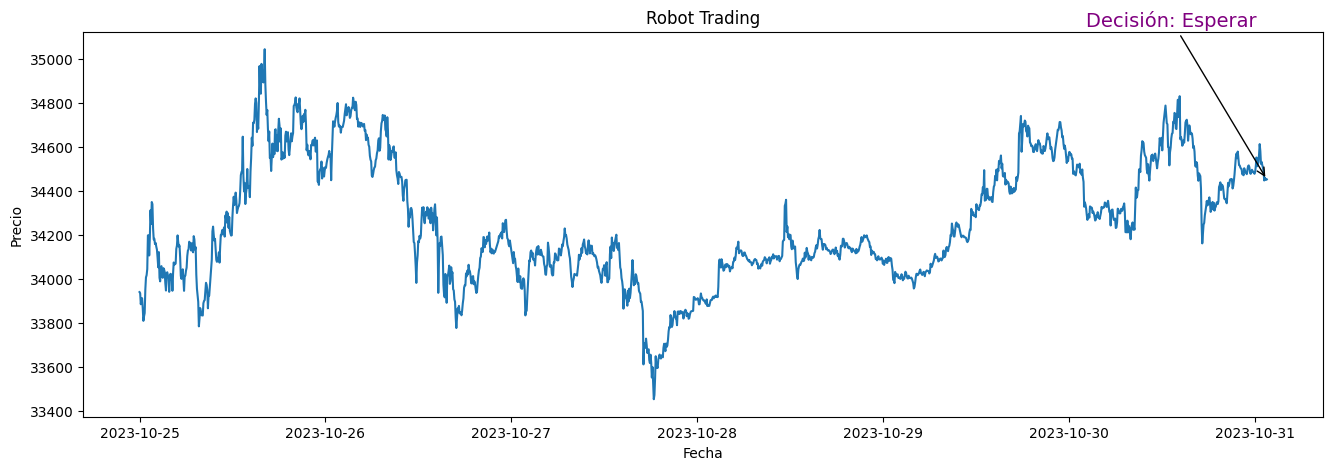

In [ ]:
while(True):
  clear_output() #este método nos permite borrar los resultados de la pantalla antes de imprimir un nuevo gráfico, y así evitar tener más de un gráfico en la pantalla
  importar_base_bitcoin()
  extraer_tendencias()
  limpieza_datos()
  tomar_decisiones()
  visualizacion()
  time.sleep(300)

**FIN.**